# Libraries

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Dataset Overview

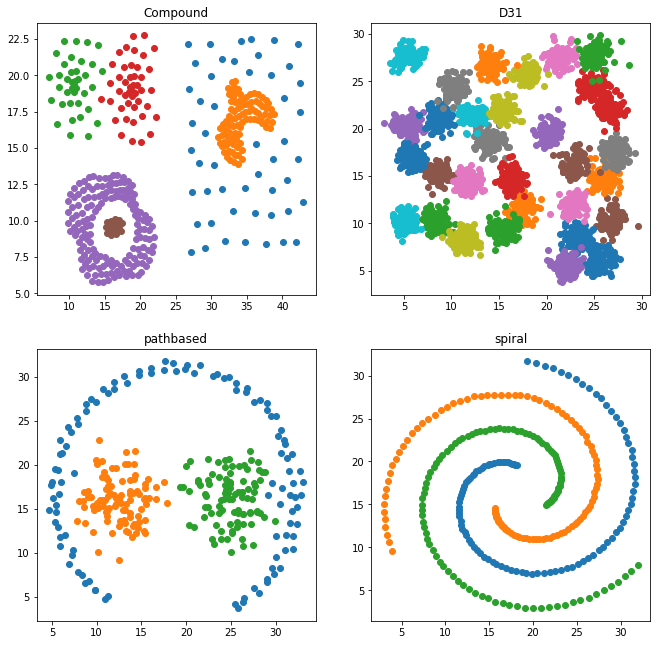

In [7]:
fig, ax = plt.subplots(2,2)

for dataset_i, dataset_name in enumerate(["Compound", "D31", "pathbased", "spiral"]):
    path = "./data/"+dataset_name+".txt"
    dataset = pd.read_csv(path, sep="\t", names=["X", "Y", "Class"])

    for class_id in set(dataset["Class"]):
        ax[int(dataset_i/2)][dataset_i%2].scatter(
            dataset[dataset["Class"]==class_id]["X"],
            dataset[dataset["Class"]==class_id]["Y"]
        )
    ax[int(dataset_i/2)][dataset_i%2].title.set_text(dataset_name)

fig.set_size_inches(11, 11)
plt.show()

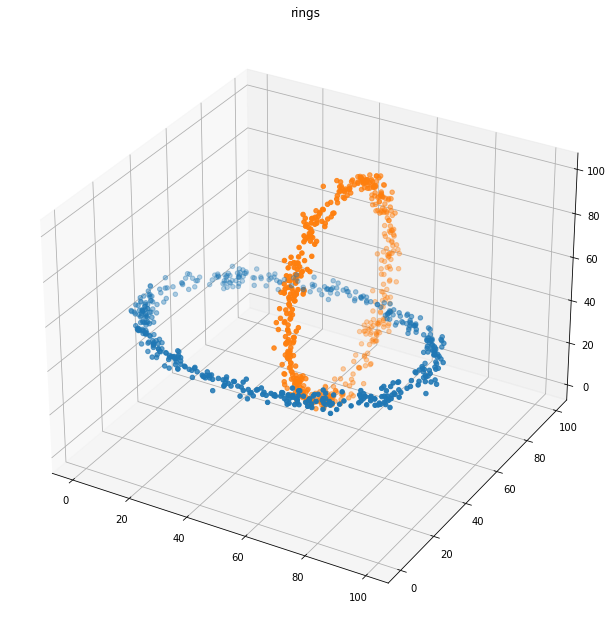

In [8]:
dataset = pd.read_csv("./data/rings.txt", sep="\t", names=["Class", "X", "Y", "Z"])

fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(projection='3d')

for class_id in set(dataset["Class"]):
    ax.scatter(dataset[dataset["Class"]==class_id]["X"],
               dataset[dataset["Class"]==class_id]["Y"],
               dataset[dataset["Class"]==class_id]["Z"]
    )
    
ax.title.set_text("rings")

plt.show()

# DBSCAN

In [61]:
def find_neighbours(dataset, data, e):
    remain_columns = list(set(dataset.columns) - set(["Class", "Status", "Cluster"]))
    
    for i, data2 in dataset.iterrows():
        dataset.at[i, "Distance"] = np.linalg.norm(data[remain_columns] - data2[remain_columns])
        
    dataset_output = dataset[dataset["Distance"]<e]
    dataset_output = dataset_output.drop([data.name])
    dataset_output = dataset_output.drop(columns = ["Distance"])
    
    del dataset["Distance"]
    
    return dataset_output

In [62]:
from queue import Queue

def dbscan(dataset, e, min_pts):
    del dataset["Class"]
    dataset["Status"] = "Unknown"
    dataset["Cluster"] = -1
    
    number_cluster = 0
    for i in list(dataset.index):
        data = dataset.iloc[i]

        if data["Status"] == "Unknown":
            neighbours = find_neighbours(dataset, data, e)
            
            if len(neighbours) < min_pts:
                dataset.at[i, "Status"] = "Outlier"
            else:
                dataset.at[i, "Status"] = "Core"
                dataset.at[i, "Cluster"] = number_cluster
                                
                q = Queue()
                
                for j, data_n in neighbours.iterrows():
                    q.put(j)
                    
                while(not q.empty()):
                    j = q.get()
                    data_n = dataset.iloc[j]
                    
                    if data_n["Status"] == "Outlier":
                        dataset.at[j, "Status"] = "Border"
                        dataset.at[j, "Cluster"] = number_cluster
                    
                    if data_n["Status"] == "Unknown":                        
                        dataset.at[j, "Cluster"] = number_cluster
                        neighbours_n = find_neighbours(dataset, data_n, e)
                        
                        if len(neighbours_n) <min_pts:
                            dataset.at[j, "Status"] = "Border"
                        else:
                            dataset.at[j, "Status"] = "Core"
                            for j, data_n in neighbours_n.iterrows():
                                q.put(j) 
                                
                number_cluster += 1
                

In [67]:
from copy import deepcopy

def plot_dbscan_result_2d(dataset_name, e, min_pts):
    fig, ax = plt.subplots(1, 2, squeeze=False)

    dataset = pd.read_csv(f"./data/{dataset_name}.txt", sep="\t", names=["X", "Y","Class"])
    
    for class_id in set(dataset["Class"]):
        ax[0][0].scatter(
            dataset[dataset["Class"]==class_id]["X"],
            dataset[dataset["Class"]==class_id]["Y"]
        )

    ax[0][0].title.set_text(f"Classes in {dataset_name}")

    clustered_dataset = deepcopy(dataset)

    dbscan(clustered_dataset, e=e, min_pts=min_pts)
    
    ax[0][1].scatter(
        clustered_dataset[clustered_dataset["Cluster"]==-1]["X"],
        clustered_dataset[clustered_dataset["Cluster"]==-1]["Y"],
        color="black"
    )

    for cluster_id in set(clustered_dataset["Cluster"]):
        if cluster_id>0:
            ax[0][1].scatter(
                clustered_dataset[clustered_dataset["Cluster"]==cluster_id]["X"],
                clustered_dataset[clustered_dataset["Cluster"]==cluster_id]["Y"]
            )

    ax[0][1].title.set_text(f"Clusters in {dataset_name}")

fig.set_size_inches(5, 11)
plt.show()   

In [ ]:
plot_dbscan_result_2d(dataset_name="spiral", e=2, min_pts=2)